In [1]:
import tifffile
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd

In [2]:
# import image (TIFF)
dir = "C:/Users/xxxx/xxxx" # change to your directory where the data file is
file1 = "HeLa_GM130_CENP-F_011.tif" # file name
img1 = tifffile.imread(os.path.join(dir, file1))

# check the shape of imported image (should be an ndarray of 3 channnels, 1024 pixels in y, 1024 pixels in x)
img1.shape

(3, 1024, 1024)

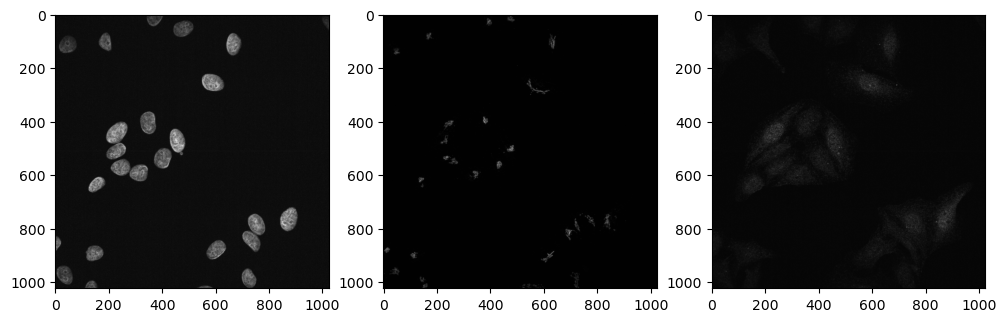

In [3]:
# show image
plt.figure(figsize=(12,6))
plt.subplot(131) # creates "1" row, "3" columns, and then put a plot in the "1st" slot (1,3,1)
plt.imshow(img1[0], cmap="gray") # image channel 0; Hoechst/DNA (shown in gray; you can play around with colormaps like "Blues" and "summer")
plt.subplot(132) # similarly, put another plot in the "2nd" slot (1,3,2)
plt.imshow(img1[1], cmap="gray") # image channel 1; GM130/Golgi (shown in gray)
plt.subplot(133)
plt.imshow(img1[2], cmap="gray") # image channel 2; CENP-F/G2 (shown in gray)
plt.show()

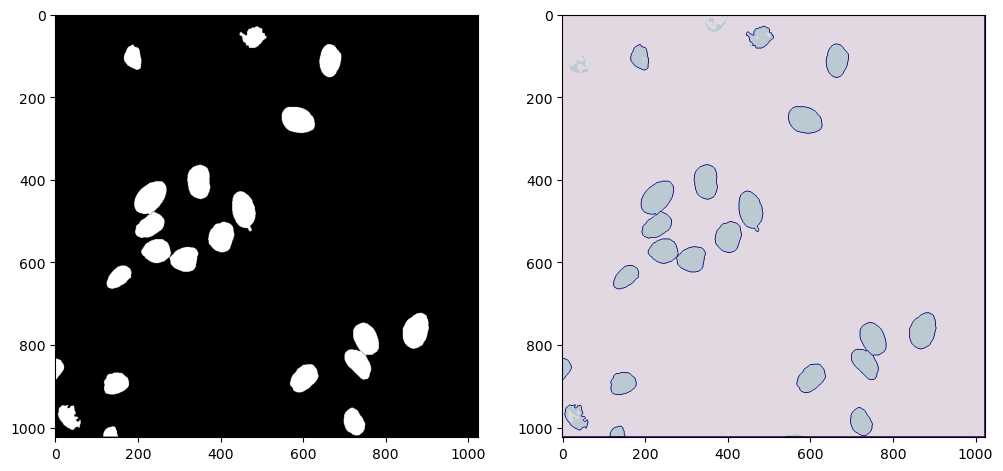

In [57]:
# review and repeat the segmentation processes in tutorial 1

# to remove very small fragments, blur image before thresholding
img1_0_blur = cv2.GaussianBlur(img1[0], (7,7), 7)

# automatic thresholding by Otsu method
threshold, img1_0_blur_bin = cv2.threshold(img1_0_blur, 0, 1, cv2.THRESH_OTSU)
img1_0_blur_bin = img1_0_blur_bin.astype(np.uint8) # convert from 16-bit to 8-bit

# segmentation using the watershed algorithm
coefficient = 0.4 # adjust this value (0-1)
kernel = np.ones((5,5),np.uint8)
sure_bg = cv2.dilate(img1_0_blur_bin, kernel, iterations=3) # sure background
dist_transform = cv2.distanceTransform(img1_0_blur_bin, cv2.DIST_L2, 5) # distance map for sure foreground
ret, sure_fg = cv2.threshold(dist_transform, coefficient*dist_transform.max(), 255, 0) # sure foreground
sure_fg = np.uint8(sure_fg) # convert to 8-bit
unknown = cv2.subtract(sure_bg, sure_fg) # unknown region
ret, markers = cv2.connectedComponents(sure_fg) # label markers
markers = markers+1 # increment all marker labels by "1" to set the background label to "1"
markers[unknown==1] = 0 # assign "0" to unknown marker labels
img1_RGB = cv2.cvtColor(img1_0_blur_bin, cv2.COLOR_GRAY2RGB)
markers = cv2.watershed(img1_RGB, markers) # watershed
outlines = np.where(markers == -1, 255, 0)
img1_0_blur_bin2 = np.where(markers > 1, 1, 0).astype(np.uint8)

# show segmentation result
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img1_0_blur_bin2, cmap="gray")
plt.subplot(122)
plt.imshow(img1_0_blur_bin*20+outlines, cmap="twilight")
plt.show()

In [58]:
# label masks (input image should be 8-bit)
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img1_0_blur_bin2, connectivity=4)

In [59]:
# the number of detected masks + background (21+1)
print(retval)

22


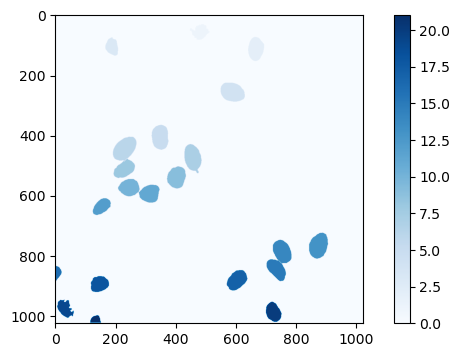

In [60]:
# show masks colored by label
# each mask has the pixel values as the label number
plt.figure(figsize=(8,4))
plt.imshow(labels, cmap="Blues")
plt.colorbar()
plt.show()

In [61]:
# list of centroids of masks ([x, y], the top one is background)
print(centroids)

[[ 515.65585705  507.39159523]
 [ 480.64467253   55.74633431]
 [ 665.30673317  112.2032419 ]
 [ 188.7536077   105.09620524]
 [ 587.54349975  256.14186851]
 [ 348.28725994  405.69299432]
 [ 230.46093399  443.97395599]
 [ 456.07224046  474.2649659 ]
 [ 229.66990291  512.08369602]
 [ 402.77690141  539.20901408]
 [ 245.73770492  573.27804564]
 [ 313.76331547  593.2908919 ]
 [ 154.45776805  636.27133479]
 [ 873.23574693  766.54173683]
 [ 752.65548529  785.94335991]
 [ 733.95727594  845.25505943]
 [   8.83857729  856.27359781]
 [ 602.72429621  881.02203182]
 [ 146.93254902  894.07411765]
 [  32.76683938  975.43240697]
 [ 723.50316206  987.47826087]
 [ 134.3125     1011.95784884]]


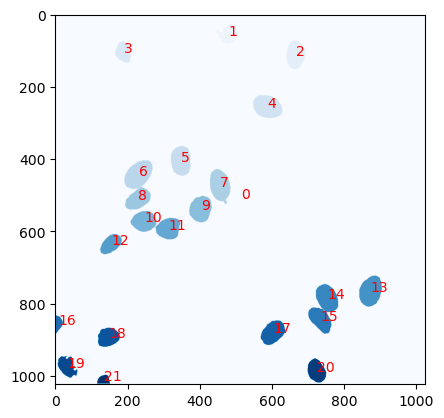

In [62]:
# show labels at the centroid of each mask (mask 0 is background)
plt.imshow(labels, cmap="Blues")
for num in range(len(centroids)): # num = number of centroid in the "centroids" list; number 0 is background
    plt.text(centroids[num, 0], centroids[num, 1], str(num), c="Red") # put text (label number) at centroids (x, y)
plt.show()

In [63]:
# make list of stats as dataframe (excluding mask 0 = background)
df_measurements = pd.DataFrame({"mask": np.array(range(1, len(centroids))),
                                "x": centroids[1:, 0],
                                "y": centroids[1:, 1],
                                "area": stats[1:, 4] # mask area is in the list "stats"
                                })

# show dataframe
df_measurements

,mask,x,y,area
0,1,480.644673,55.746334,2046
1,2,665.306733,112.203242,3208
2,3,188.753608,105.096205,1871
3,4,587.543500,256.141869,4046
4,5,348.287260,405.692994,3697
5,6,230.460934,443.973956,4454
6,7,456.072240,474.264966,3959
7,8,229.669903,512.083696,2987
8,9,402.776901,539.209014,3550
9,10,245.737705,573.278046,3111


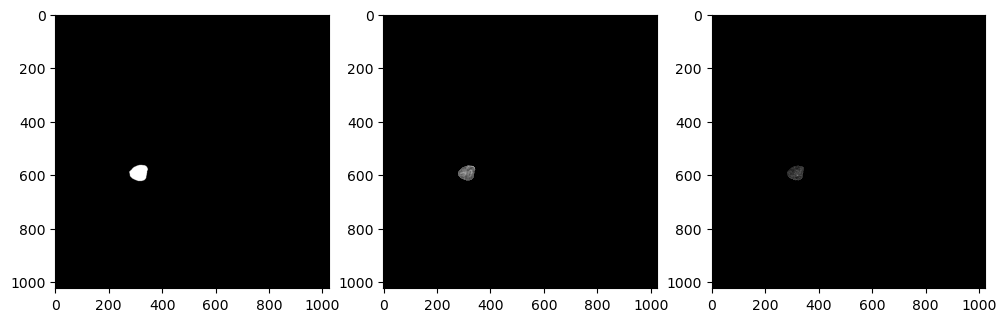

In [64]:
# pick a single mask and apply to the original images
num = 11 # mask number
mask = np.where(labels == num, 1, 0) # if the pixel value = num, assign 1, otherwise assign 0
img1_masked = img1 * mask # apply mask
plt.figure(figsize=(12,6))
plt.subplot(131)
plt.imshow(mask, cmap="gray")
plt.subplot(132)
plt.imshow(img1_masked[0], cmap="gray", vmin = 400, vmax = 800)
plt.subplot(133)
plt.imshow(img1_masked[2], cmap="gray", vmin = 400, vmax = 700)
plt.show()

In [65]:
# measure mean fluorescence intensities and standard deviations of nucleus regions

# prepare empty lists
mean_hoechst = []
std_hoechst = []
mean_CENPF = []
std_CENPF = []

# measure
for num in range (1, len(centroids)):
    mask = np.where(labels == num, 1, 0) # if the pixel value = num, assign 1, otherwise assign 0
    img1_masked = img1 * mask # apply mask

    # channel 0 (Hoechst/DNA)
    img1_masked_0 = img1_masked[0]
    img1_masked_0_nonzero = img1_masked_0[np.nonzero(img1_masked_0)] 
    mean_hoechst_ = np.mean(img1_masked_0_nonzero) # mean of non-zero values in channel 0 (Hoechst)
    std_hoechst_ = np.std(img1_masked_0_nonzero) # standard deviation

    # channel 2 (CEPN-F/G2)
    img1_masked_2 = img1_masked[2]
    img1_masked_2_nonzero = img1_masked_2[np.nonzero(img1_masked_2)] 
    mean_CENPF_ = np.mean(img1_masked_2_nonzero) # mean of non-zero values in channel 2 (CENP-F)
    std_CENPF_ = np.std(img1_masked_2_nonzero) # standard deviation

    # append measured values to lists
    mean_hoechst.append(mean_hoechst_)
    std_hoechst.append(std_hoechst_)
    mean_CENPF.append(mean_CENPF_)
    std_CENPF.append(std_CENPF_)

In [66]:
# add measured values to the dataframe
df_measurements["mean_hoechst"] = mean_hoechst
df_measurements["std_hoechst"] = std_hoechst
df_measurements["mean_CENPF"] = mean_CENPF
df_measurements["std_CENPF"] = std_CENPF

# show dataframe
df_measurements

,mask,x,y,area,mean_hoechst,std_hoechst,mean_CENPF,std_CENPF
0,1,480.644673,55.746334,2046,514.942815,23.813776,442.859238,13.123212
1,2,665.306733,112.203242,3208,592.369701,46.450526,480.278055,27.434858
2,3,188.753608,105.096205,1871,534.835382,29.726144,445.885088,13.574906
3,4,587.543500,256.141869,4046,611.592931,52.452018,501.057093,38.453494
4,5,348.287260,405.692994,3697,554.172843,37.651329,462.628077,25.485938
5,6,230.460934,443.973956,4454,615.259542,49.373652,520.419623,45.628792
6,7,456.072240,474.264966,3959,634.019702,58.863644,501.863602,40.976124
7,8,229.669903,512.083696,2987,574.910613,49.128982,464.927017,24.169542
8,9,402.776901,539.209014,3550,558.743380,40.464073,462.269577,23.206707
9,10,245.737705,573.278046,3111,572.287046,38.482225,467.318226,26.257294


In [67]:
# copy the dataframe and add label
df_measurements_1 = df_measurements.copy()
df_measurements_1["file"] = "HeLa_GM130_CENP-F_011"

# show dataframe
df_measurements_1

,mask,x,y,area,mean_hoechst,std_hoechst,mean_CENPF,std_CENPF,file
0,1,480.644673,55.746334,2046,514.942815,23.813776,442.859238,13.123212,HeLa_GM130_CENP-F_011
1,2,665.306733,112.203242,3208,592.369701,46.450526,480.278055,27.434858,HeLa_GM130_CENP-F_011
2,3,188.753608,105.096205,1871,534.835382,29.726144,445.885088,13.574906,HeLa_GM130_CENP-F_011
3,4,587.543500,256.141869,4046,611.592931,52.452018,501.057093,38.453494,HeLa_GM130_CENP-F_011
4,5,348.287260,405.692994,3697,554.172843,37.651329,462.628077,25.485938,HeLa_GM130_CENP-F_011
5,6,230.460934,443.973956,4454,615.259542,49.373652,520.419623,45.628792,HeLa_GM130_CENP-F_011
6,7,456.072240,474.264966,3959,634.019702,58.863644,501.863602,40.976124,HeLa_GM130_CENP-F_011
7,8,229.669903,512.083696,2987,574.910613,49.128982,464.927017,24.169542,HeLa_GM130_CENP-F_011
8,9,402.776901,539.209014,3550,558.743380,40.464073,462.269577,23.206707,HeLa_GM130_CENP-F_011
9,10,245.737705,573.278046,3111,572.287046,38.482225,467.318226,26.257294,HeLa_GM130_CENP-F_011


In [68]:
# import another image
file2 = "HeLa_GM130_CENP-F_012.tif" # file name
img2 = tifffile.imread(os.path.join(dir, file2))

# check the shape of imported image (should be an ndarray of 3 channnels, 1024 pixels in y, 1024 pixels in x)
img2.shape

(3, 1024, 1024)

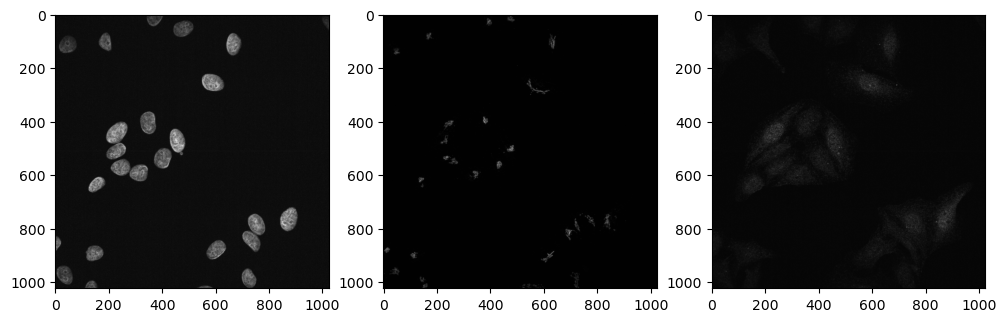

In [69]:
# show image
plt.figure(figsize=(12,6))
plt.subplot(131) # creates "1" row, "3" columns, and then put a plot in the "1st" slot (1,3,1)
plt.imshow(img1[0], cmap="gray") # image channel 0; Hoechst/DNA (shown in gray; you can play around with colormaps like "Blues" and "summer")
plt.subplot(132) # similarly, put another plot in the "2nd" slot (1,3,2)
plt.imshow(img1[1], cmap="gray") # image channel 1; GM130/Golgi (shown in gray)
plt.subplot(133)
plt.imshow(img1[2], cmap="gray") # image channel 2; CENP-F/G2 (shown in gray)
plt.show()

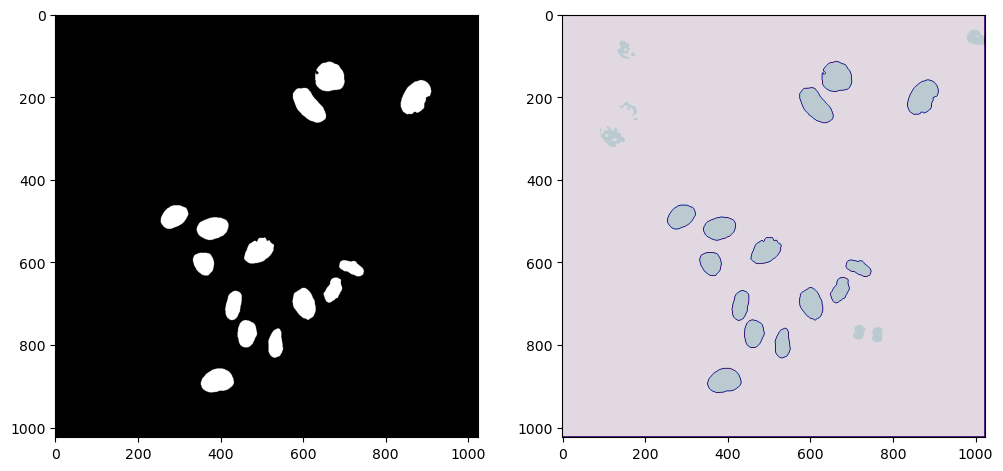

In [70]:
# repeat the segmentation processes

# to remove very small fragments, blur image before thresholding
img2_0_blur = cv2.GaussianBlur(img2[0], (7,7), 7)

# automatic thresholding by Otsu method
threshold, img2_0_blur_bin = cv2.threshold(img2_0_blur, 0, 1, cv2.THRESH_OTSU)
img2_0_blur_bin = img2_0_blur_bin.astype(np.uint8) # convert from 16-bit to 8-bit

# segmentation using the watershed algorithm
coefficient = 0.4 # adjust this value (0-1)
kernel = np.ones((5,5),np.uint8)
sure_bg = cv2.dilate(img2_0_blur_bin, kernel, iterations=3) # sure background
dist_transform = cv2.distanceTransform(img2_0_blur_bin, cv2.DIST_L2, 5) # distance map for sure foreground
ret, sure_fg = cv2.threshold(dist_transform, coefficient*dist_transform.max(), 255, 0) # sure foreground
sure_fg = np.uint8(sure_fg) # convert to 8-bit
unknown = cv2.subtract(sure_bg, sure_fg) # unknown region
ret, markers = cv2.connectedComponents(sure_fg) # label markers
markers = markers+1 # increment all marker labels by "1" to set the background label to "1"
markers[unknown==1] = 0 # assign "0" to unknown marker labels
img2_RGB = cv2.cvtColor(img2_0_blur_bin, cv2.COLOR_GRAY2RGB)
markers = cv2.watershed(img2_RGB, markers) # watershed
outlines = np.where(markers == -1, 255, 0)
img2_0_blur_bin2 = np.where(markers > 1, 1, 0).astype(np.uint8)

# label masks (input image should be 8-bit)
retval, labels, stats, centroids = cv2.connectedComponentsWithStats(img2_0_blur_bin2, connectivity=4)

# show segmentation result
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img2_0_blur_bin2, cmap="gray")
plt.subplot(122)
plt.imshow(img2_0_blur_bin*20+outlines, cmap="twilight")
plt.show()

In [71]:
# make list of stats as dataframe (excluding mask 0 = background)
df_measurements_2 = pd.DataFrame({"mask": np.array(range(1, len(centroids))),
                                "x": centroids[1:, 0],
                                "y": centroids[1:, 1],
                                "area": stats[1:, 4] # mask area is in the list "stats"
                                })

# show dataframe
df_measurements_2

,mask,x,y,area
0,1,664.646131,152.246427,4058
1,2,872.299216,200.926146,4211
2,3,613.914409,221.216255,4171
3,4,288.019320,490.211807,2795
4,5,381.285449,518.233127,3230
5,6,493.070931,573.387587,3158
6,7,359.913518,603.188894,2197
7,8,717.881588,614.059206,1537
8,9,673.075311,668.000566,1766
9,10,603.249117,700.741573,3115


In [72]:
# measure mean fluorescence intensities and standard deviations of nucleus regions

# prepare empty lists
mean_hoechst = []
std_hoechst = []
mean_CENPF = []
std_CENPF = []

# measure
for num in range (1, len(centroids)):
    mask = np.where(labels == num, 1, 0) # if the pixel value = num, assign 1, otherwise assign 0
    img2_masked = img2 * mask # apply mask

    # channel 0
    img2_masked_0 = img2_masked[0]
    img2_masked_0_nonzero = img2_masked_0[np.nonzero(img2_masked_0)] 
    mean_hoechst_ = np.mean(img2_masked_0_nonzero) # mean of non-zero values in channel 0 (Hoechst)
    std_hoechst_ = np.std(img2_masked_0_nonzero) # standard deviation

    # channel 2
    img2_masked_2 = img2_masked[2]
    img2_masked_2_nonzero = img2_masked_2[np.nonzero(img2_masked_2)] 
    mean_CENPF_ = np.mean(img2_masked_2_nonzero) # mean of non-zero values in channel 2 (CENP-F)
    std_CENPF_ = np.std(img2_masked_2_nonzero) # standard deviation

    # append measured values to lists
    mean_hoechst.append(mean_hoechst_)
    std_hoechst.append(std_hoechst_)
    mean_CENPF.append(mean_CENPF_)
    std_CENPF.append(std_CENPF_)

In [73]:
# add measured values to the dataframe
df_measurements_2["mean_hoechst"] = mean_hoechst
df_measurements_2["std_hoechst"] = std_hoechst
df_measurements_2["mean_CENPF"] = mean_CENPF
df_measurements_2["std_CENPF"] = std_CENPF

# add label
df_measurements_2["file"] = "HeLa_GM130_CENP-F_012"

# show dataframe
df_measurements_2

,mask,x,y,area,mean_hoechst,std_hoechst,mean_CENPF,std_CENPF,file
0,1,664.646131,152.246427,4058,572.366437,37.615084,475.617792,27.982693,HeLa_GM130_CENP-F_012
1,2,872.299216,200.926146,4211,572.032059,42.930606,485.054381,29.646843,HeLa_GM130_CENP-F_012
2,3,613.914409,221.216255,4171,604.317909,46.165122,512.731479,38.604696,HeLa_GM130_CENP-F_012
3,4,288.019320,490.211807,2795,628.504114,47.552305,486.184258,29.669112,HeLa_GM130_CENP-F_012
4,5,381.285449,518.233127,3230,631.411455,47.843541,481.000619,27.154734,HeLa_GM130_CENP-F_012
5,6,493.070931,573.387587,3158,567.139962,41.242982,474.936985,29.669685,HeLa_GM130_CENP-F_012
6,7,359.913518,603.188894,2197,624.470187,48.560307,462.972235,21.568547,HeLa_GM130_CENP-F_012
7,8,717.881588,614.059206,1537,843.927781,154.917656,642.188679,89.120102,HeLa_GM130_CENP-F_012
8,9,673.075311,668.000566,1766,827.422424,144.804587,640.001699,83.173954,HeLa_GM130_CENP-F_012
9,10,603.249117,700.741573,3115,607.546709,42.025422,479.995506,28.463160,HeLa_GM130_CENP-F_012


In [74]:
# combine dataframes
df_concat = pd.concat([df_measurements_1, df_measurements_2]).reset_index()
df_concat

,index,mask,x,y,area,mean_hoechst,std_hoechst,mean_CENPF,std_CENPF,file
0,0,1,480.644673,55.746334,2046,514.942815,23.813776,442.859238,13.123212,HeLa_GM130_CENP-F_011
1,1,2,665.306733,112.203242,3208,592.369701,46.450526,480.278055,27.434858,HeLa_GM130_CENP-F_011
2,2,3,188.753608,105.096205,1871,534.835382,29.726144,445.885088,13.574906,HeLa_GM130_CENP-F_011
3,3,4,587.543500,256.141869,4046,611.592931,52.452018,501.057093,38.453494,HeLa_GM130_CENP-F_011
4,4,5,348.287260,405.692994,3697,554.172843,37.651329,462.628077,25.485938,HeLa_GM130_CENP-F_011
5,5,6,230.460934,443.973956,4454,615.259542,49.373652,520.419623,45.628792,HeLa_GM130_CENP-F_011
6,6,7,456.072240,474.264966,3959,634.019702,58.863644,501.863602,40.976124,HeLa_GM130_CENP-F_011
7,7,8,229.669903,512.083696,2987,574.910613,49.128982,464.927017,24.169542,HeLa_GM130_CENP-F_011
8,8,9,402.776901,539.209014,3550,558.743380,40.464073,462.269577,23.206707,HeLa_GM130_CENP-F_011
9,9,10,245.737705,573.278046,3111,572.287046,38.482225,467.318226,26.257294,HeLa_GM130_CENP-F_011


In [75]:
# you can extract data of interest
df_img011 = df_concat[df_concat["file"]=="HeLa_GM130_CENP-F_011"] # extract data with "file" values = "HeLa_GM130_CENP-F_011"
df_img011

,index,mask,x,y,area,mean_hoechst,std_hoechst,mean_CENPF,std_CENPF,file
0,0,1,480.644673,55.746334,2046,514.942815,23.813776,442.859238,13.123212,HeLa_GM130_CENP-F_011
1,1,2,665.306733,112.203242,3208,592.369701,46.450526,480.278055,27.434858,HeLa_GM130_CENP-F_011
2,2,3,188.753608,105.096205,1871,534.835382,29.726144,445.885088,13.574906,HeLa_GM130_CENP-F_011
3,3,4,587.543500,256.141869,4046,611.592931,52.452018,501.057093,38.453494,HeLa_GM130_CENP-F_011
4,4,5,348.287260,405.692994,3697,554.172843,37.651329,462.628077,25.485938,HeLa_GM130_CENP-F_011
5,5,6,230.460934,443.973956,4454,615.259542,49.373652,520.419623,45.628792,HeLa_GM130_CENP-F_011
6,6,7,456.072240,474.264966,3959,634.019702,58.863644,501.863602,40.976124,HeLa_GM130_CENP-F_011
7,7,8,229.669903,512.083696,2987,574.910613,49.128982,464.927017,24.169542,HeLa_GM130_CENP-F_011
8,8,9,402.776901,539.209014,3550,558.743380,40.464073,462.269577,23.206707,HeLa_GM130_CENP-F_011
9,9,10,245.737705,573.278046,3111,572.287046,38.482225,467.318226,26.257294,HeLa_GM130_CENP-F_011


In [76]:
# extract column
df_img011["mean_CENPF"]

0     442.859238
1     480.278055
2     445.885088
3     501.057093
4     462.628077
5     520.419623
6     501.863602
7     464.927017
8     462.269577
9     467.318226
10    465.016388
11    481.555799
12    516.185470
13    487.675557
14    455.648571
15    455.031464
16    453.153611
17    448.485490
18    436.723976
19    443.469170
20    437.488372
Name: mean_CENPF, dtype: float64

In [ ]:
# you can try to drop data of small nuclei (e.g., area < 1000) from the dataframe
# such small nuclei may not be well segmented and measurements could be inaccurate

Plot data

In [25]:
import seaborn as sns

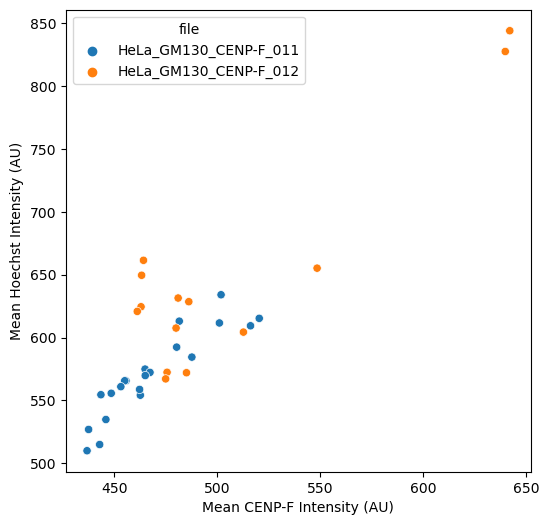

In [79]:
plt.figure(figsize=(6,6))
sns.scatterplot(data = df_concat, x = "mean_CENPF", y = "mean_hoechst", hue = "file")
plt.xlabel("Mean CENP-F Intensity (AU)")
plt.ylabel("Mean Hoechst Intensity (AU)")
plt.show()

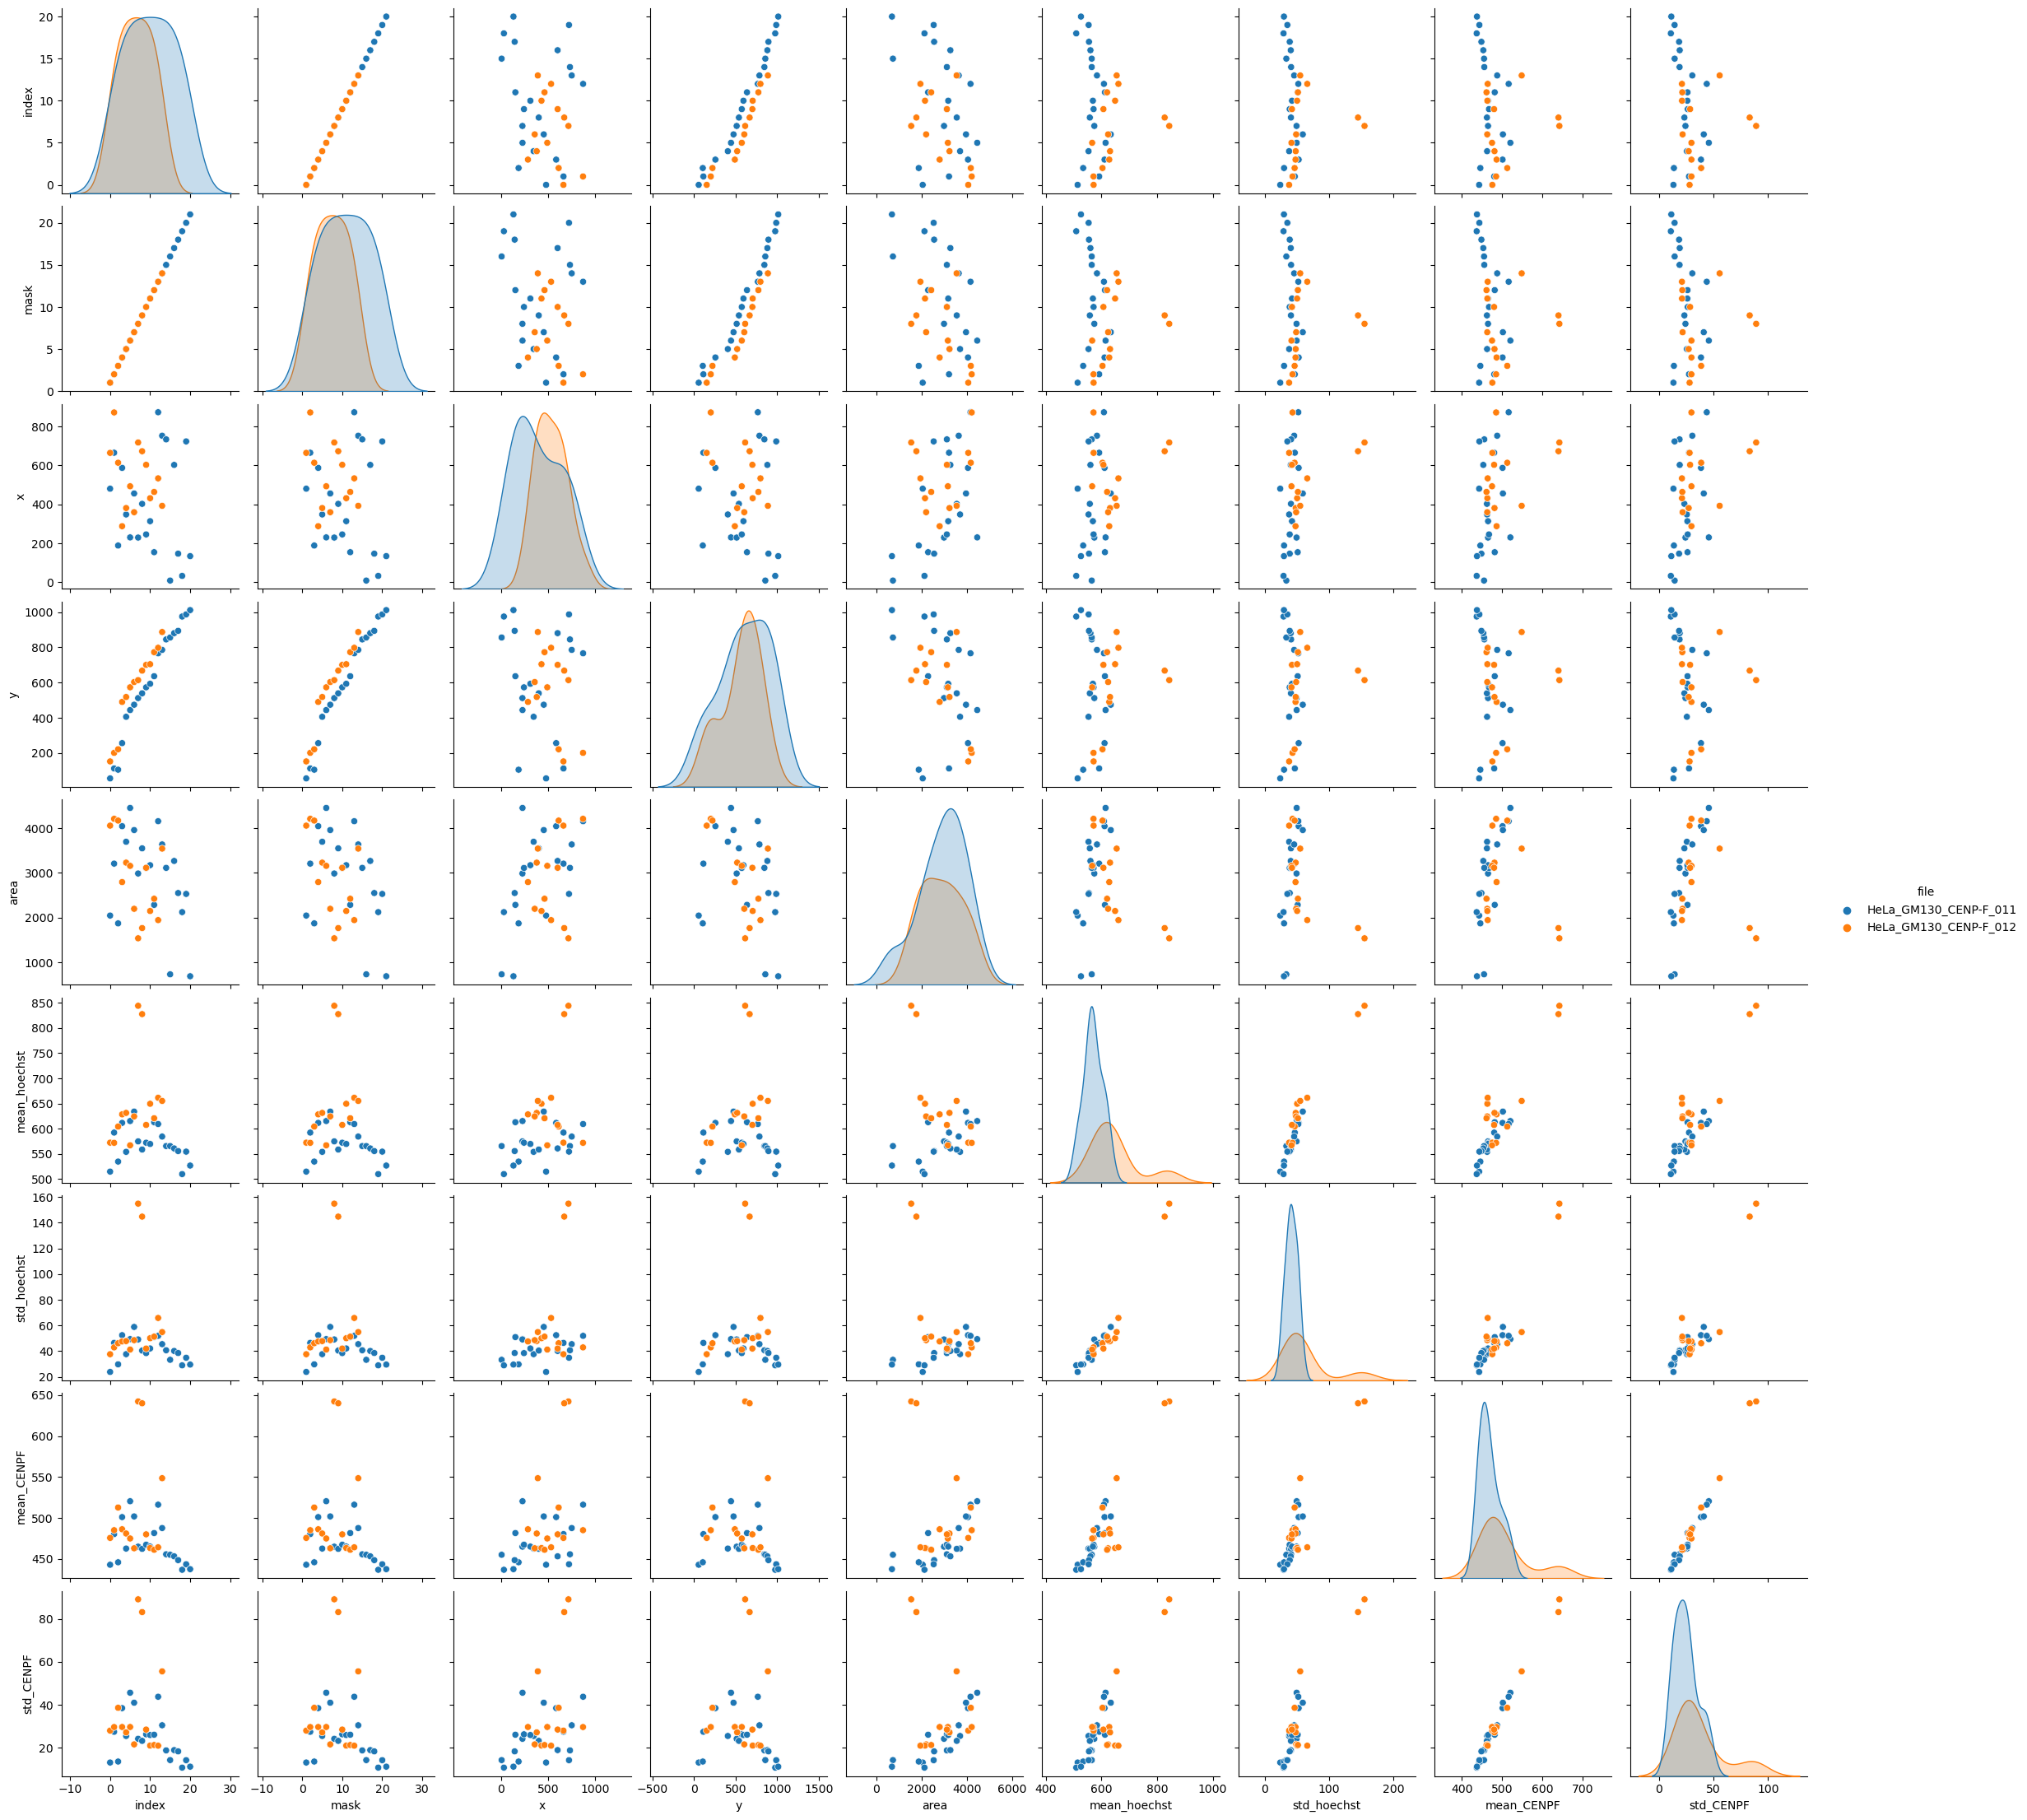

In [80]:
# pair plot
sns.pairplot(data = df_concat, hue = "file")
plt.show()